In [1]:
spark

In [1]:
from pyspark.sql.functions import col, isnan, isnull, when, count, udf, mean
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#Set up the path
bucket = 'my-bigdata-project-ar/'
filename = 'landing/*'
file_path = 'gs://' + bucket + filename 

#Define schema for dataset
schema = StructType([
    StructField("npi", StringType(), nullable=False),
    StructField("nppes_provider_last_org_name", StringType(), nullable=True),
    StructField("nppes_provider_first_name", StringType(), nullable=True),
    StructField("nppes_provider_mi", StringType(), nullable=True),
    StructField("nppes_credentials", StringType(), nullable=True),
    StructField("nppes_provider_gender", StringType(), nullable=True),
    StructField("nppes_entity_code", StringType(), nullable=True),
    StructField("nppes_provider_street1", StringType(), nullable=True),
    StructField("nppes_provider_street2", StringType(), nullable=True),
    StructField("nppes_provider_city", StringType(), nullable=True),
    StructField("nppes_provider_zip", StringType(), nullable=True),
    StructField("nppes_provider_state", StringType(), nullable=True),
    StructField("nppes_provider_country", StringType(), nullable=True),
    StructField("provider_type", StringType(), nullable=True),
    StructField("medicare_participation_indicator", StringType(), nullable=True),
    StructField("place_of_service", StringType(), nullable=False),
    StructField("hcpcs_code", StringType(), nullable=False),
    StructField("hcpcs_description", StringType(), nullable=True),
    StructField("hcpcs_drug_indicator", StringType(), nullable=True),
    StructField("line_srvc_cnt", FloatType(), nullable=True),
    StructField("bene_unique_cnt", IntegerType(), nullable=True),
    StructField("bene_day_srvc_cnt", IntegerType(), nullable=True),
    StructField("average_medicare_allowed_amt", FloatType(), nullable=True),
    StructField("stdev_medicare_allowed_amt", FloatType(), nullable=True),
    StructField("average_submitted_chrg_amt", FloatType(), nullable=True),
    StructField("stdev_submitted_chrg_amt", FloatType(), nullable=True),
    StructField("average_medicare_payment_amt", FloatType(), nullable=True),
    StructField("stdev_medicare_payment_amt", FloatType(), nullable=True)
])


# Read data from GCS bucket to spark DF
sdf = spark.read.csv(file_path, schema=schema, header=True)

In [4]:
#Print Schema of data to verify integrity z

sdf.printSchema()

root
 |-- npi: string (nullable = true)
 |-- nppes_provider_last_org_name: string (nullable = true)
 |-- nppes_provider_first_name: string (nullable = true)
 |-- nppes_provider_mi: string (nullable = true)
 |-- nppes_credentials: string (nullable = true)
 |-- nppes_provider_gender: string (nullable = true)
 |-- nppes_entity_code: string (nullable = true)
 |-- nppes_provider_street1: string (nullable = true)
 |-- nppes_provider_street2: string (nullable = true)
 |-- nppes_provider_city: string (nullable = true)
 |-- nppes_provider_zip: string (nullable = true)
 |-- nppes_provider_state: string (nullable = true)
 |-- nppes_provider_country: string (nullable = true)
 |-- provider_type: string (nullable = true)
 |-- medicare_participation_indicator: string (nullable = true)
 |-- place_of_service: string (nullable = true)
 |-- hcpcs_code: string (nullable = true)
 |-- hcpcs_description: string (nullable = true)
 |-- hcpcs_drug_indicator: string (nullable = true)
 |-- line_srvc_cnt: float (n

In [5]:
# Number of records
sdf = sdf.dropDuplicates()

print(f"There are {sdf.count()} records")


24/04/23 00:55:17 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


There are 37254908 records


In [6]:
# Drop unneeded columns

sdf = sdf.drop('nppes_entity_code',
 'nppes_provider_gender',
 'nppes_provider_last_org_name',
 'nppes_provider_first_name',
 'nppes_credentials',
 'nppes_provider_mi',
 'nppes_provider_street1',
 'nppes_provider_street2',
 'nppes_provider_city',
 'nppes_provider_zip',
 'nppes_provider_state',
 'nppes_provider_country',
 'provider_type',
 'medicare_participation_indicator',
 'place_of_service',
 'hcpcs_description',
 'stdev_medicare_payment_amt',
 'stdev_submitted_chrg_amt',
 'stdev_medicare_allowed_amt'
)

sdf.columns

['npi',
 'hcpcs_code',
 'hcpcs_drug_indicator',
 'line_srvc_cnt',
 'bene_unique_cnt',
 'bene_day_srvc_cnt',
 'average_medicare_allowed_amt',
 'average_submitted_chrg_amt',
 'average_medicare_payment_amt']

In [7]:
#Calculate amount of null values in each columns
null_counts = sdf.select([count(when(isnull(c), c)).alias(c) for c in sdf.columns])

In [8]:
print(null_counts.limit(10).toPandas())

   npi  hcpcs_code  hcpcs_drug_indicator  line_srvc_cnt  bene_unique_cnt  \
0    0           0                     0              0                0   

   bene_day_srvc_cnt  average_medicare_allowed_amt  \
0                  0                             0   

   average_submitted_chrg_amt  average_medicare_payment_amt  
0                           0                      18813771  


In [9]:
sdf.show()

+----------+----------+--------------------+-------------+---------------+-----------------+----------------------------+--------------------------+----------------------------+
|       npi|hcpcs_code|hcpcs_drug_indicator|line_srvc_cnt|bene_unique_cnt|bene_day_srvc_cnt|average_medicare_allowed_amt|average_submitted_chrg_amt|average_medicare_payment_amt|
+----------+----------+--------------------+-------------+---------------+-----------------+----------------------------+--------------------------+----------------------------+
|1700850997|     00104|                   N|         19.0|             11|               19|                   58.600525|                  45.94263|                        null|
|1225244403|     00142|                   N|         41.0|             41|               41|                   116.18878|                  91.09244|                        null|
|1922393305|     00300|                   N|         13.0|             13|               13|                  

In [10]:
# Fill in nulls in average_medicare_payment_amt with mean

mean_value = sdf.select(mean(col("average_medicare_payment_amt"))).collect()[0][0]

sdf = sdf.na.fill(mean_value, ["average_medicare_payment_amt"])

In [11]:
# # Graph gender distribution

# gender_counts = sdf.groupBy("gender").count()
# gender_counts_pd = gender_counts.toPandas()

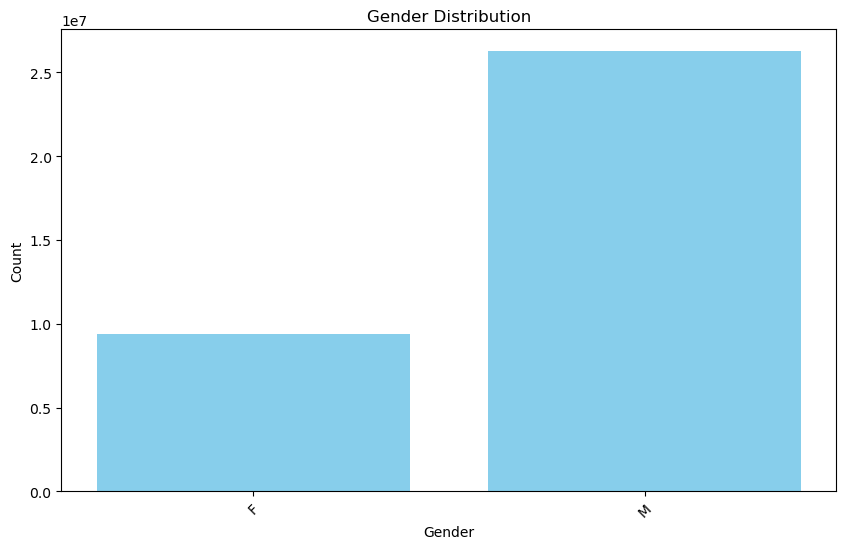

In [12]:
# gender_counts_pd = gender_counts_pd.dropna()

# plt.figure(figsize=(10, 6))
# plt.bar(gender_counts_pd['gender'], gender_counts_pd['count'], color='skyblue')
# plt.title('Gender Distribution')
# plt.xlabel('Gender')
# plt.ylabel('Count')
# plt.xticks(rotation=45)
# plt.show()



In [11]:
# Statistics for numeric data

numeric_column_stats_df = sdf.describe(['average_medicare_allowed_amt', 'average_submitted_chrg_amt', 'average_medicare_payment_amt'])
numeric_column_stats_df.show()

+-------+----------------------------+--------------------------+----------------------------+
|summary|average_medicare_allowed_amt|average_submitted_chrg_amt|average_medicare_payment_amt|
+-------+----------------------------+--------------------------+----------------------------+
|  count|                    37254908|                  37254908|                    37254908|
|   mean|           97.80453057486203|        188.57081105988655|           74.55727346089901|
| stddev|          220.80919331798526|         601.3494517137523|          115.17141713668602|
|    min|                  3.33333E-5|                       0.0|                         0.0|
|    max|                   52601.473|                  98099.82|                   37012.324|
+-------+----------------------------+--------------------------+----------------------------+



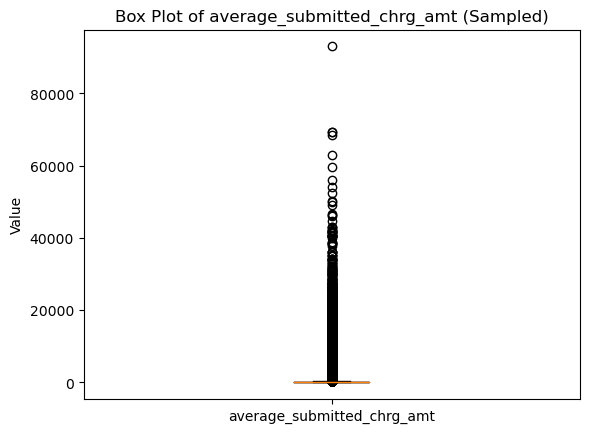

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


sampled_data = sdf.select('average_submitted_chrg_amt').sample(withReplacement=False, fraction=0.1).rdd.map(lambda row: row[0]).collect()


pdf = pd.DataFrame(sampled_data, columns=['average_submitted_chrg_amt'])


plt.boxplot(pdf['average_submitted_chrg_amt'])
plt.title('Box Plot of average_submitted_chrg_amt (Sampled)')
plt.ylabel('Value')
plt.xticks([1], ['average_submitted_chrg_amt'])
plt.show()

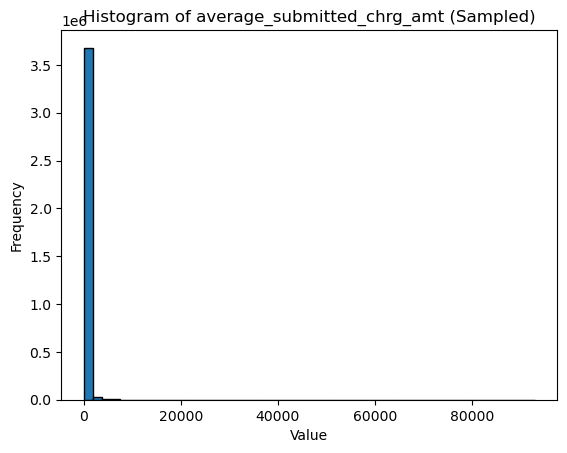

In [13]:
pdf = pd.DataFrame(sampled_data, columns=['average_submitted_chrg_amt'])

# Create a histogram of the data
plt.hist(pdf['average_submitted_chrg_amt'], bins=50, edgecolor='black')
plt.title('Histogram of average_submitted_chrg_amt (Sampled)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [14]:
# Save the cleaned data in a new file. Use Parquet file format.
output_file_path= f"gs://{bucket}/cleaned/cleaned_physicians_and_other_supplier.parquet"
sdf.write.mode("overwrite").parquet(output_file_path)
